In [1]:
import numpy as np
import xarray as xr
import proplot as pplt
import matplotlib.pyplot as plt
from mod_LIM import *
from mod_plot_enm import *

%load_ext autoreload
%autoreload 2

In [2]:
base = '/data3/kinya/pyworks/LIM/MERRA2/data'
f = f'{base}/state.7dm.anom.DJF.1981_2019.nc'
# f = f'{base}/state.5dm.anom.DJF.1980_2019.nc'

ds = xr.open_dataset(f)

# select regions
# dsr = xr.merge([ds.sel(lat=slice(20, 80), lon=slice(120, 270))[['sf850', 'sf250', 'IVT']],
#                 ds.sel(lat=slice(-15, 15))[['olr']]]) 

dsr = xr.merge([ds.sel(lat=slice(20, 80), lon=slice(120, 270))[['sf850', 'sf250', 'IVT']],
                ds.sel(lat=slice(-15, 15))[['olr', 'sst']]])

In [3]:
# num_eigs = pd.DataFrame({'ne': [13, 26, 21], 
#                          'variables': [['sf850', 'sf250'], 'IVT', 'olr']},
#                         index=['sf', 'IVT', 'olr'])

num_eigs = pd.DataFrame({'ne': [10, 18, 9, 5], 
                         'variables': [['sf850', 'sf250'], 'IVT', 'olr', 'sst']},
                        index=['sf', 'IVT', 'olr', 'sst'])

lim_name = '_'.join([f"{num_eigs.loc[i, 'ne']}"
                     f"{''.join(num_eigs.loc[i, 'variables'])}"
                     for i in num_eigs.index])
print(lim_name)

pc, eof, std_factor, pca_score = calc_pc_eof(dsr, num_eigs)
    
# make a state vector
x = pc_to_state(pc)

# LIM propagator
tau0 = 5
G = calc_lim_g(x, tau0)

10sf850sf250_18IVT_9olr_5sst


/home/kinya/miniconda3/envs/basicf9/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/kinya/miniconda3/envs/basicf9/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/kinya/miniconda3/envs/basicf9/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/kinya/miniconda3/envs/basicf9/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/kinya/miniconda3/envs/basicf9/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, 

In [4]:
# ENMs
enm, eigvecs = calc_enms(x, G, tau0, eof, num_eigs, std_factor)

# # L2 norm 
wgt = np.cos(np.deg2rad(dsr.lat))
#enm['SSTnorm'] = (np.abs(enm['sst'])**2).weighted(wgt).sum(dim=['lat', 'lon'])**0.5
enm['sf250norm'] = (np.abs(enm['sf250'])**2).weighted(wgt).sum(dim=['lat', 'lon'])**0.5
enm['olrnorm'] = (np.abs(enm['olr'])**2).weighted(wgt).sum(dim=['lat', 'lon'])**0.5

# sort first by period, then by e-folding time
eigvecs = eigvecs.sortby([np.abs(enm['period']), enm['e_folding']])
enm = enm.sortby([np.abs(enm['period']), enm['e_folding']])

# reset enm index
eigvecs = eigvecs.assign_coords(enm=np.arange(enm.enm.size)+1)
enm = enm.assign_coords(enm=np.arange(enm.enm.size)+1)

# extract positive freq
enmp = enm.sel(enm=enm['freq'] >= 0)
enm_nonst_p = enmp.sel(enm=enmp['freq'] > 0).enm.data  # non-stationary
enm_st_p = enmp.sel(enm=enmp['freq'] == 0).enm.data    # stationary

# Time series of z
z = proj_x_to_z(x, eigvecs)

print(f"e-folding time: {enm['e_folding'].min().data:.2f} day -- {enm['e_folding'].max().data:.2f} day")

e-folding time: 4.71 day -- 255.62 day


/data3/kinya/pyworks/LIM/LIM_weight/mod_LIM.py:813: RuntimeWarning: divide by zero encountered in true_divide
  'period': (('enm'), 2*np.pi/omega),


In [5]:
# |e|
eigvecs_mod = (eigvecs * eigvecs.conjugate()).real

# Each variable contribution
eigvecs_cont = eigvecs_mod.unstack().sum(dim='mode')

# SST modes
sst_enmp = enmp.enm[eigvecs_cont.sel(enm=enmp.enm, variable='sst') > 0.1].data
sst_enm_nonst_p = np.intersect1d(sst_enmp, enm_nonst_p)
sst_enm_st_p = np.intersect1d(sst_enmp, enm_st_p)

# MJO mode
lead_mjo_enmp = enmp.enm[eigvecs_cont.sel(enm=enmp.enm, variable='olr') > 0.3].data

## MJO-related

In [6]:
# rmm composite
f = '/data3/kinya/pyworks/AR/data/RMM_clean.csv'
df = pd.read_csv(f, index_col=0, parse_dates=True)
#print(df['RMM1'] @ df['RMM2'])
#df = df['1981-12-01':'2019-12-29']

# DJF, amplitude > 1
#dfw = df.loc[(df.index.month <=2) | (df.index.month ==12)]
dfw = df.loc[ds.time]
dfw_mjo = dfw.loc[dfw.amplitude > 1]

rmms = np.arange(1, 9)

lst = []
lstz = []
for rmm in rmms:
    tt = dfw_mjo[dfw_mjo.phase == rmm].index
    lstz.append(z.sel(time=tt).mean(dim='time'))
    
zcom = xr.concat(lstz, pd.Index(rmms, name='rmm'))
zcomp = zcom.sel(enm = enm['freq'] >= 0)

In [7]:
# sort enms based on |z|
for rmm in rmms:
    zabs = np.abs(zcom.sel(rmm=rmm))
    idx = zabs > zabs.mean() + 0.5 * zabs.std()
    enm_lst = zcom.enm[idx].sortby(zabs[idx], ascending=False).data
    print(rmm, enm_lst)

1 [13 14  3  4  8  7 30 29]
2 [14 13  8  7 12 11]
3 [14 13  8  7 29 30 40 12 11]
4 [14 13 39  3  4]
5 [13 14 11 12  7  8  3  4 34 33  5  6 16 15]
6 [13 14  8  7 29 30 12 11  4  3]
7 [ 8  7 11 12 14 13  5  6]
8 [13 14  3  4 39 16 15]


In [8]:
# Search for MJO enms
zcom_abs = np.abs(zcom)
idx_all = zcom_abs > zcom_abs.mean(dim='enm') + 1 * zcom_abs.std('enm')
enm_lst = zcom.enm[idx_all.any(dim='rmm')].data

# Select intraseasonal signals
idx_mjo = ((np.abs(enm.sel(enm=enm_lst)['period']) > 30) & 
           (np.abs(enm.sel(enm=enm_lst)['period']) < 100))
idx_mjo_p = ((enm.sel(enm=enm_lst)['period'] > 30) & 
             (enm.sel(enm=enm_lst)['period'] < 100))
mjo_enm = enm_lst[idx_mjo.data]
mjo_enmp = enm_lst[idx_mjo_p.data]

# leading mode
lead_mjo_enm = mjo_enm[idx_all.sel(enm=mjo_enm).all(dim='rmm').data]
lead_mjo_enmp = mjo_enmp[idx_all.sel(enm=mjo_enmp).all(dim='rmm').data]

print('Leading MJO ENMs:', lead_mjo_enm)
print('MJO ENMs:', mjo_enm)
print('Dropped ENMs:', enm_lst[~idx_mjo.data])

Leading MJO ENMs: [13 14]
MJO ENMs: [ 3  4  7  8 11 12 13 14]
Dropped ENMs: [39]


# plot

In [10]:
enm_labels = make_enm_labels(enm)

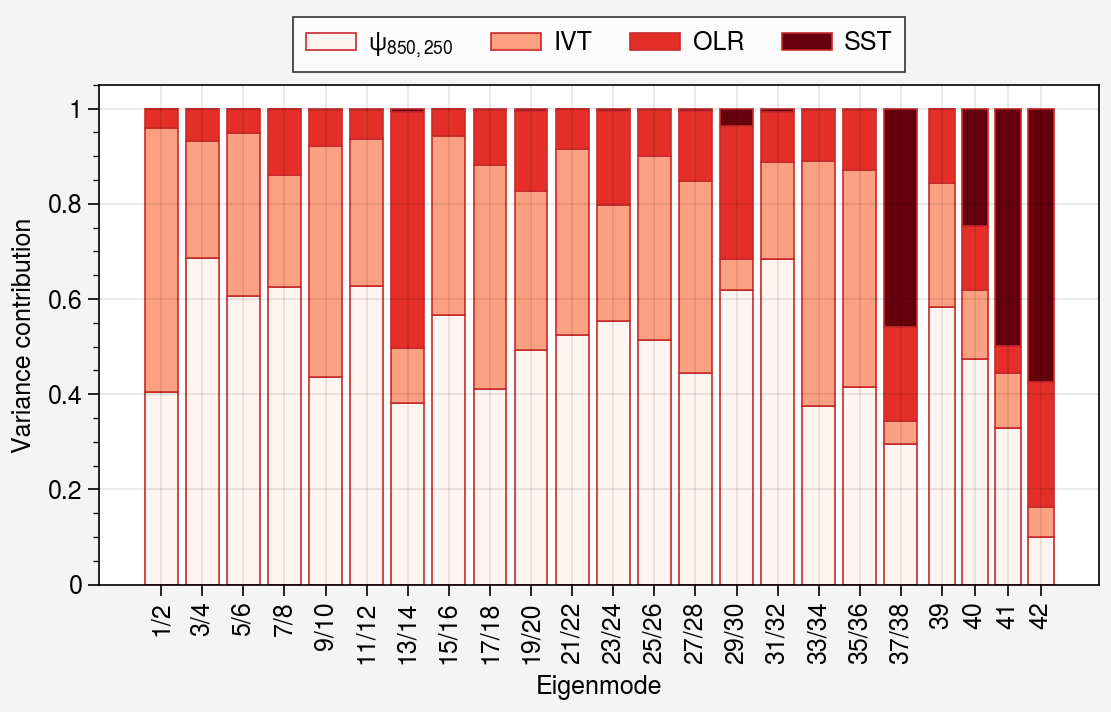

In [13]:
labels = [r'$\psi_{850, 250}$', 'IVT', 'OLR', 'SST']
xlocator = np.concatenate((np.arange(len(enm_nonst_p)), 
                           np.arange(len(enm_st_p))*.8 + len(enm_nonst_p)))

fig, ax = pplt.subplots(axwidth=5, refaspect=2)
ax.bar(xlocator,
       eigvecs_cont.sel(enm=enmp.enm.data).data, stack=True, 
       cycle='Reds', edgecolor='red9', labels=labels)

ax.legend(loc='t', ncol=4)

ax.format(xrotation=90,
          xlocator=xlocator,
          xticklabels=enm_labels,
          xminorlocator='null',
          xlabel='Eigenmode',
          ylabel='Variance contribution',
          )
fig.save('png/enm_variance_contribution.png')

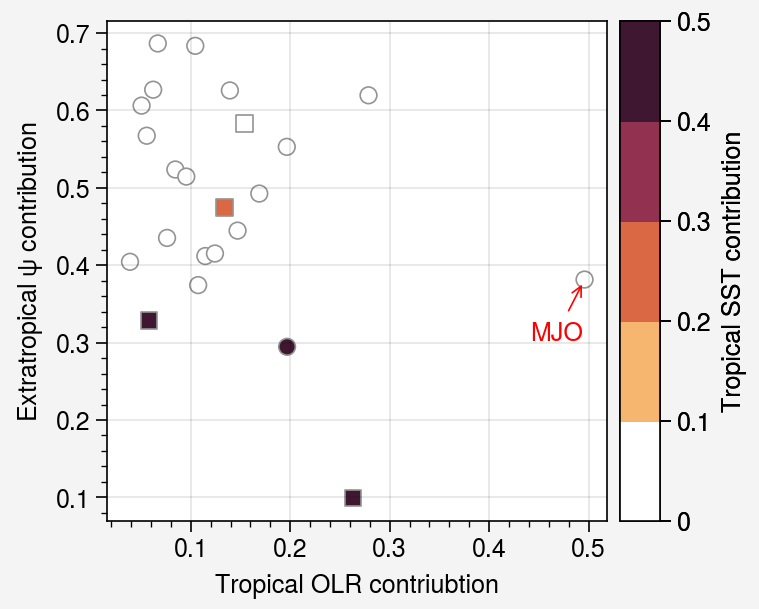

In [26]:
levels = np.linspace(0, 0.5, 6)

fig, ax = pplt.subplots()

m = ax.scatter(
    eigvecs_cont.sel(enm=enm_st_p, variable='olr'), 
    eigvecs_cont.sel(enm=enm_st_p, variable='sf'),
    c=eigvecs_cont.sel(enm=enm_st_p, variable='sst'),
    #s=eigvecs_cont.sel(enm=enm_st_p, variable='IVT')*500,
    absolute_size=True,
    ec='gray', m='s', levels=levels,
)

m = ax.scatter(
    eigvecs_cont.sel(enm=enm_nonst_p, variable='olr'), 
    eigvecs_cont.sel(enm=enm_nonst_p, variable='sf'),
    c=eigvecs_cont.sel(enm=enm_nonst_p, variable='sst'),
    #s=eigvecs_cont.sel(enm=enm_nonst_p, variable='IVT')*500,
    absolute_size=True,
    ec='gray', levels=levels,
)

ax.annotate('MJO',
            (eigvecs_cont.sel(enm=lead_mjo_enmp, variable='olr'), 
             eigvecs_cont.sel(enm=lead_mjo_enmp, variable='sf')),
            xytext=(-10, -15), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='r'),
            va='top', ha='center', c='r',
           )  

ax.colorbar(m, label='Tropical SST contribution')
ax.format(xlabel='Tropical OLR contriubtion',
          ylabel=r'Extratropical $\psi$ contribution')

In [18]:
np.linspace(0, 0.5, 6)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5])

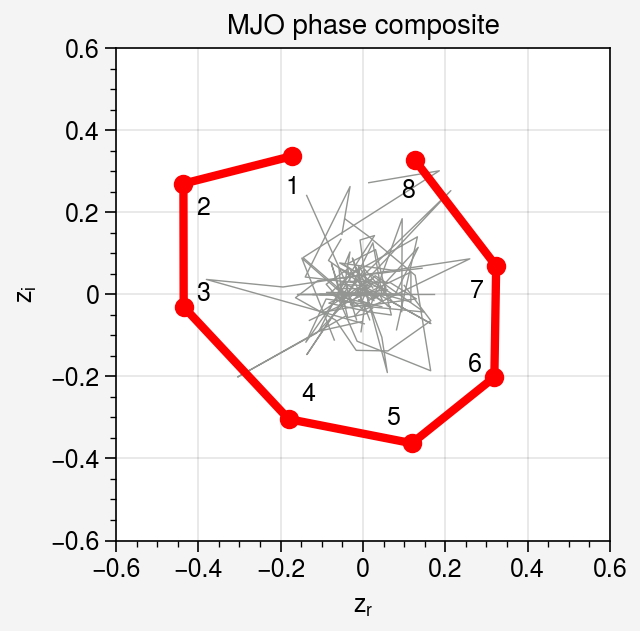

In [9]:
lim = .6
xoffs = np.array([0, 1, 1, 1, -1, -1, -1, 0]) * 0.03
yoffs = np.array([-1.5, -1, 1, 1, 1, 1, -1, -1.5]) * 0.03
has=['center', 'left', 'left', 'left', 'right', 'right', 'right', 'right']
vas=['top', 'top', 'center', 'bottom', 'bottom', 'center', 'top', 'top']

fig, ax = pplt.subplots(journal='ams1')
#ax.axvline(0, c='k', lw=.5)
#ax.axhline(0, c='k', lw=.5)

ax.plot(zcomp.real, zcomp.imag, c='gray', lw=.5)
# ax.plot(zcomp.sel(enm=mjo_enmp).real, zcomp.sel(enm=mjo_enmp).imag,
#         lw=3, m='o', markevery=[0])
ax.plot(zcomp.sel(enm=lead_mjo_enmp).real, zcomp.sel(enm=lead_mjo_enmp).imag,
        c='r', lw=3, m='o', 
        #markevery=[0], mec='r', mfc='None',
        )
for rmm in range(1, 9):
    ax.text(zcomp.sel(enm=lead_mjo_enmp, rmm=rmm).real + xoffs[rmm-1], 
            zcomp.sel(enm=lead_mjo_enmp, rmm=rmm).imag + yoffs[rmm-1],
            rmm, ha=has[rmm-1], va=vas[rmm-1])
#ax.scatter(zcomp.sel(enm=mjo_enmp, rmm=1).real, zcomp.sel(enm=mjo_enmp, rmm=1).imag, m='.)

# circle1 = plt.Circle((0, 0), .1, color='k', fill=False, lw=.5, ls='--')
# ax.add_artist(circle1)

ax.format(title='MJO phase composite',
          xlim=(-lim, lim), ylim=(-lim, lim),
          xlabel=r'$z_r$', ylabel=r'$z_i$', labelsize=9)
#fig.save('png/enm_mjo_comp.png')
fig.save(f'png/enm_mjo_comp_{lim_name}.png')

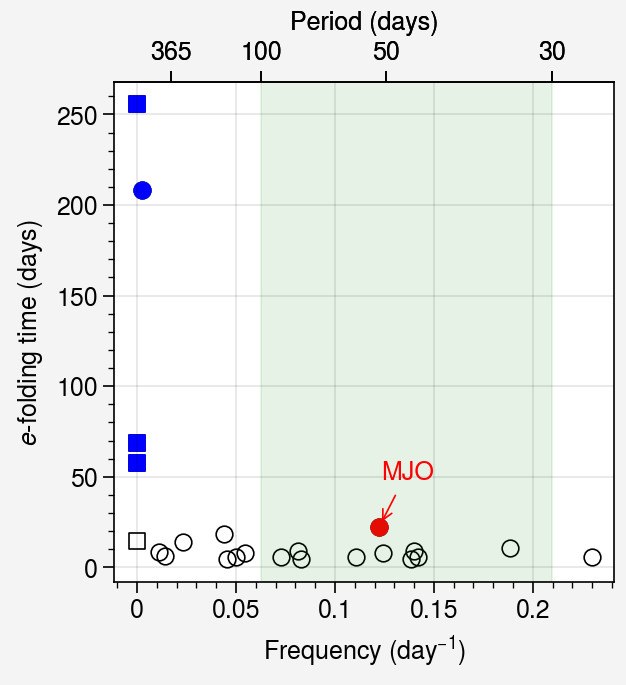

In [54]:
fig, ax = pplt.subplots()

ax.scatter(enmp.sel(enm=enm_st_p)['freq'], enmp.sel(enm=enm_st_p)['e_folding'], 
           fc='None', ec='k', m='s')
ax.scatter(enmp.sel(enm=enm_nonst_p)['freq'], enmp.sel(enm=enm_nonst_p)['e_folding'], 
           fc='None', ec='k')

ax.scatter(enmp.sel(enm=lead_mjo_enmp)['freq'], enmp.sel(enm=lead_mjo_enmp)['e_folding'], 
           fc='r', ec='r')
           
ax.scatter(enmp.sel(enm=sst_enm_nonst_p)['freq'], enmp.sel(enm=sst_enm_nonst_p)['e_folding'], 
           fc='b', ec='b')
ax.scatter(enmp.sel(enm=sst_enm_st_p)['freq'], enmp.sel(enm=sst_enm_st_p)['e_folding'], 
           fc='b', ec='b', m='s')

ax.annotate('MJO',
            (enmp.sel(enm=lead_mjo_enmp)['freq'], enmp.sel(enm=lead_mjo_enmp)['e_folding']),
            xytext=(10, 15), textcoords='offset points',
            va='bottom', ha='center', c='r',
            arrowprops=dict(arrowstyle='->', color='r'),
           )

ax.axvspan(2*np.pi/100, 2*np.pi/30, color='g', alpha=0.1)
ax.dualx(lambda x: 2*np.pi/x, label='Period (days)', locator=[20, 30, 50, 100, 365])
ax.format(xlabel=r'Frequency $(day^{-1})$', ylabel=r'$\mathit{e}$-folding time (days)')


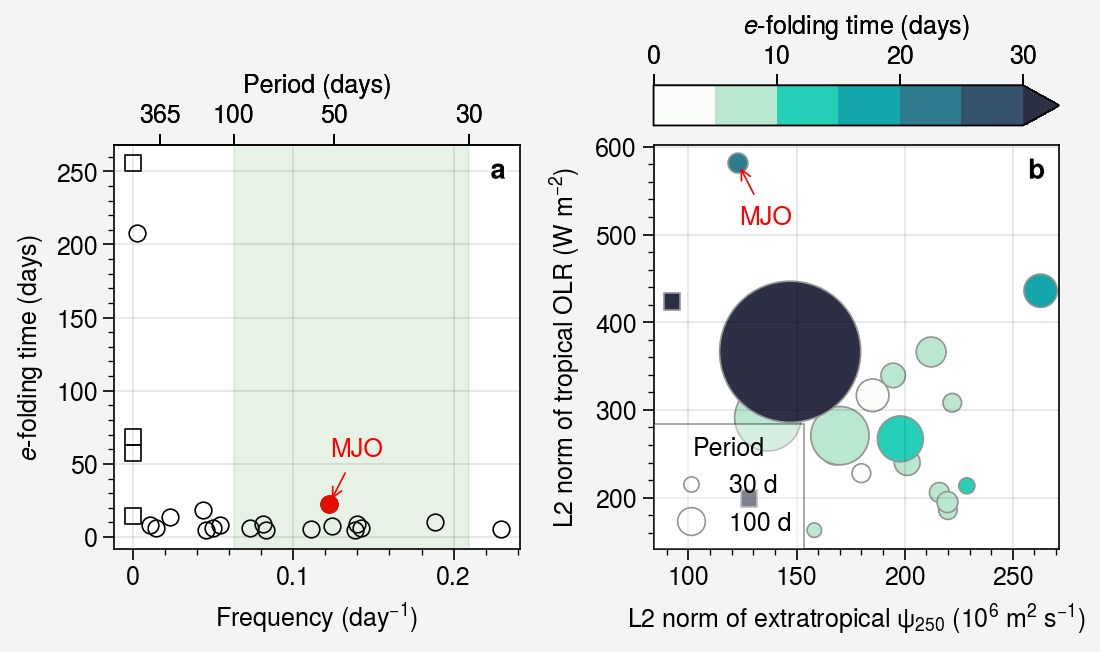

In [10]:
fig, axs = pplt.subplots(ncols=2, journal='ams3', share=0)
axs.format(abc=True, abcloc='ur')
ax = axs[0]
ax.scatter(enmp.sel(enm=enm_st_p)['freq'], enmp.sel(enm=enm_st_p)['e_folding'], 
           fc='None', ec='k', m='s')
ax.scatter(enmp.sel(enm=enm_nonst_p)['freq'], enmp.sel(enm=enm_nonst_p)['e_folding'], 
           fc='None', ec='k')

ax.scatter(enmp.sel(enm=lead_mjo_enmp)['freq'], enmp.sel(enm=lead_mjo_enmp)['e_folding'], 
           fc='r', ec='r')
# ax.scatter(enmp.sel(enm=mjo_enmp)['freq'], enmp.sel(enm=mjo_enmp)['e_folding'], 
#            fc='None', ec='r')
ax.annotate('MJO',
            (enmp.sel(enm=lead_mjo_enmp)['freq'], enmp.sel(enm=lead_mjo_enmp)['e_folding']),
            xytext=(10, 15), textcoords='offset points',
            va='bottom', ha='center', c='r',
            arrowprops=dict(arrowstyle='->', color='r'),
           )

ax.axvspan(2*np.pi/100, 2*np.pi/30, color='g', alpha=0.1)
ax.dualx(lambda x: 2*np.pi/x, label='Period (days)', locator=[20, 30, 50, 100, 365])
ax.format(xlabel=r'Frequency $(day^{-1})$', ylabel=r'$\mathit{e}$-folding time (days)')

ax = axs[1]
levels=np.linspace(0, 30, 7)
cmap = 'marine'

m = ax.scatter(enmp.sel(enm=enm_st_p)['sf250norm'], enmp.sel(enm=enm_st_p)['olrnorm'], 
               ec='gray', c=enmp.sel(enm=enm_st_p)['e_folding'], m='s',
               levels=levels, extend='max', cmap=cmap,
              )
m = ax.scatter(enmp.sel(enm=enm_nonst_p)['sf250norm'], enmp.sel(enm=enm_nonst_p)['olrnorm'], 
               ec='gray', c=enmp.sel(enm=enm_nonst_p)['e_folding'], 
               s=enmp.sel(enm=enm_nonst_p)['period'], absolute_size=True,
               levels=levels, extend='max', cmap=cmap,
              )

# m1 = ax.scatter(enmp.sel(enm=lead_mjo_enmp)['sf250norm'], enmp.sel(enm=lead_mjo_enmp)['olrnorm'], 
#                 ec='r', lw=1, 
#                 c=enmp.sel(enm=lead_mjo_enmp)['e_folding'], 
#                 s=enmp.sel(enm=lead_mjo_enmp)['period'], absolute_size=True,
#                 levels=levels, extend='max', cmap=cmap
#                )

ax.annotate('MJO',
            (enmp.sel(enm=lead_mjo_enmp)['sf250norm'], enmp.sel(enm=lead_mjo_enmp)['olrnorm']),
            xytext=(10, -15), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='r'),
            va='top', ha='center', c='r',
           )         

ax.colorbar(m, loc='t', label=r'$\mathit{e}$-folding time (days)')
ax.legend(*m.legend_elements('sizes', num=[30, 100], 
                             color='None', markeredgecolor='gray',
                             fmt='{x} d'
                             ), 
          loc='ll', ncol=1, 
          #frame=False, 
          label='Period', alpha=0.4)

ax.format(ylabel=r'L2 norm of tropical OLR $(W\ m^{-2})$',
          xlabel=r'L2 norm of extratropical $\psi_{250}\ (10^6\ m^2\ s^{-1})$',
          #ylim=(150, None),
         )
fig.save(f'png/figure2.png', dpi=300)    

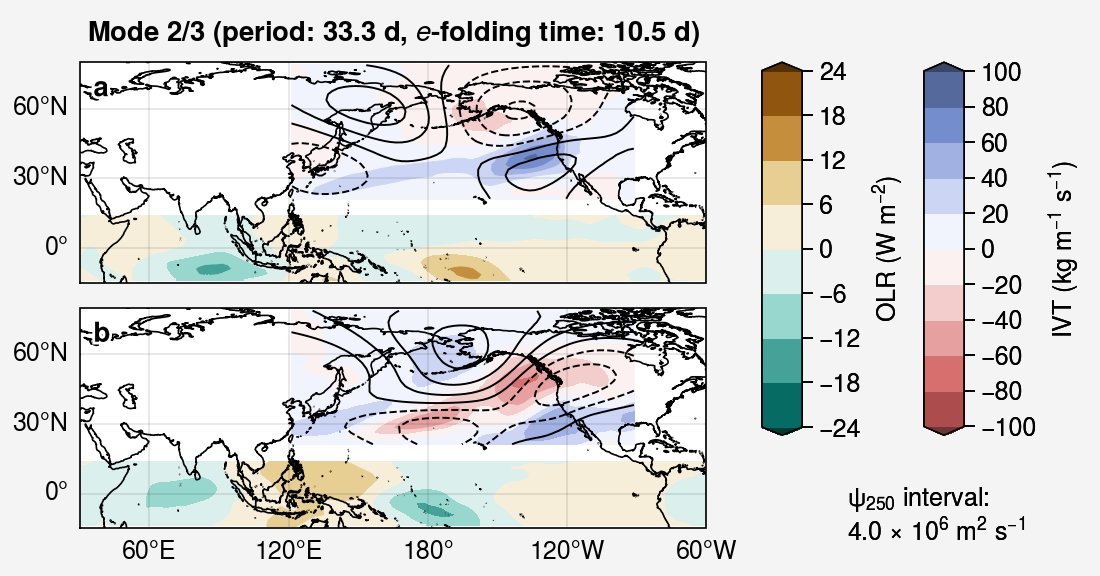

In [11]:
plot_enm_olrsfivt(enm, 2, cbar=True)

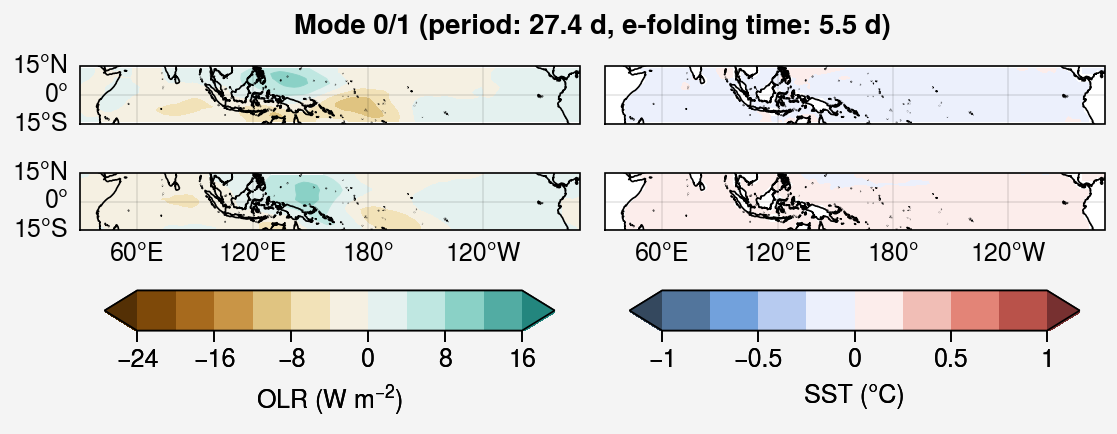

In [17]:
plot_enm_tr(enm, 0, cbar=True)

In [56]:
for i in enmp.enm.data:
    #plot_enm_tr(enm, i, show=False)
    #plot_enm_sst(enm, i, show=False)
    plot_enm_olrsfivt(enm, i, show=False)

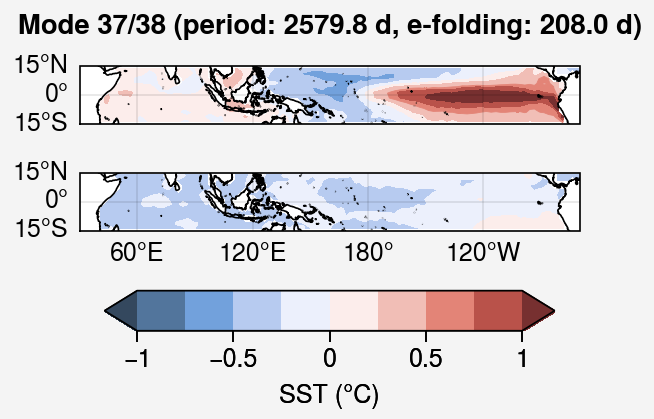

In [37]:
plot_enm_sst(enm, 37, cbar=True)

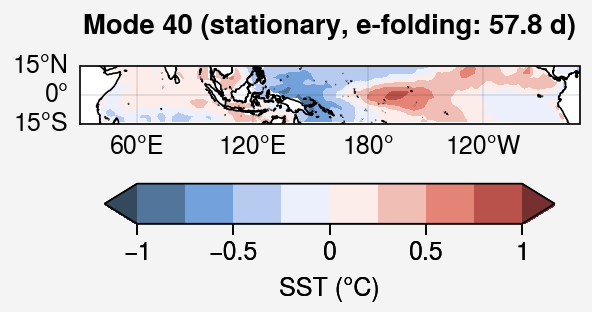

In [40]:
plot_enm_sst(enm, 40, cbar=True)